# Anomaly Detection Challenge

This notebook experiments with different anomaly detection algorithms on the HEP dataset.
We'll compare Isolation Forest and Flow Matching approaches.

In [1]:
# Import necessary libraries
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    accuracy_score,
    RocCurveDisplay,
)
import time

# Import fAD components
from fad.data.loaders import _load_h5_challenge_dataset
from fad.data.preprocessing import Preprocessor, StandardScalerFunction, TSNEFunction
from fad.models.statistical import IsolationForestDetector
from fad.models.flow_matching import FlowMatchingAnomalyDetector
from fad.models.NNs import MLP_wrapper

In [2]:
import hls4ml

## 1. Data Loading and Exploration

In [3]:
# Set paths to dataset files
path_bkg = (
    "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/background_for_training.h5"
)
path_anom = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/Ato4l_lepFilter_13TeV_filtered.h5"

# Load challenge datasets
print("Loading datasets...")
dataset = _load_h5_challenge_dataset(path_bkg, path_anom, n_train=100000, n_test=60000)

# Print dataset information
print(f"Training set shape: {dataset.train.shape}")
print(f"Test set shape: {dataset.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset.test_labels)}")

# dataset 2 with different anomaly process
path_anom2 = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5"

# Load challenge datasets
print("Loading datasets...")
dataset2 = _load_h5_challenge_dataset(
    path_bkg, path_anom2, n_train=100000, n_test=60000
)
# Print dataset information
print(f"Training set shape: {dataset2.train.shape}")
print(f"Test set shape: {dataset2.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset2.test_labels)}")

Loading datasets...
Training set shape: (100000, 76)
Test set shape: (115969, 76)
Number of anomalies in test set: 55969.0
Loading datasets...
Training set shape: (100000, 76)
Test set shape: (120000, 76)
Number of anomalies in test set: 60000.0


## 2. Data Preprocessing

In [4]:
# Preprocess data with standardization
print("Preprocessing data...")
preprocessor = Preprocessor([StandardScalerFunction()])
X_train = preprocessor.transform(dataset.train, fit=True)
X_test = preprocessor.transform(dataset.test)
print("Done")
X_test2 = preprocessor.transform(dataset2.test)

Preprocessing data...
Done


## 3. t-SNE Visualization

t-SNE reduces dimensionality while preserving local structure, helping us visualize high-dimensional data.

In [5]:
# Visualize data with t-SNE (subsample for speed)
# print("Visualizing data with t-SNE (this may take a while)...")
# subsample_size = min(5000, len(X_test))
# indices = np.random.choice(len(X_test), subsample_size, replace=False)

# tsne_preprocessor = Preprocessor([TSNEFunction(n_components=2)])
# X_test_tsne = tsne_preprocessor.transform(X_test[indices], fit=True)
# y_test_tsne = dataset.test_labels[indices]

# # Plot t-SNE visualization
# plt.figure(figsize=(10, 8))
# plt.scatter(
#     X_test_tsne[y_test_tsne == 0, 0],
#     X_test_tsne[y_test_tsne == 0, 1],
#     c="blue",
#     alpha=0.5,
#     label="Normal",
# )
# plt.scatter(
#     X_test_tsne[y_test_tsne == 1, 0],
#     X_test_tsne[y_test_tsne == 1, 1],
#     c="red",
#     alpha=0.5,
#     label="Anomaly",
# )
# plt.title("t-SNE Visualization of Test Data")
# plt.legend()
# plt.tight_layout()
# plt.show()

## 4. Train and Evaluate Models

We'll train and evaluate two models:
1. Isolation Forest (traditional algorithm)
2. Flow Matching (advanced generative model)

In [6]:
# Dictionary to store results
results = {}

### 4.1 Isolation Forest

In [7]:
print("Training Isolation Forest...")
start_time = time.time()
iso_forest = IsolationForestDetector(contamination=0.01)
iso_forest.fit(X_train)
iso_time = time.time() - start_time
print(f"Training time: {iso_time:.2f} seconds")

# Predict anomaly scores
iso_scores = iso_forest.predict(X_test)
iso_auc = roc_auc_score(dataset.test_labels, iso_scores)
iso_ap = average_precision_score(dataset.test_labels, iso_scores)
iso_accuracy = accuracy_score(dataset.test_labels, iso_scores < 0)
print(f"Accuracy: {iso_accuracy:.4f}")
print(f"AUC-ROC: {iso_auc:.4f}")
print(f"Average Precision: {iso_ap:.4f}")

results["Isolation Forest"] = {
    "scores": iso_scores,
    "auc": iso_auc,
    "ap": iso_ap,
    "time": iso_time,
}

Training Isolation Forest...


Training time: 0.49 seconds
Accuracy: 0.4313
AUC-ROC: 0.8789
Average Precision: 0.8552


In [8]:
print(X_train.shape[1])

76


### 4.2 Flow Matching

In [9]:
config_path = "../fad/models/configs/flow_matching.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
flow_matching = FlowMatchingAnomalyDetector(
    input_dim=X_train.shape[1],
    hidden_dim=config["hidden_dim"],
    model_type=config["model_type"],
    num_layers=config["num_layers"],
    dropout_rate=config["dropout_rate"],
    use_batch_norm=config["use_batch_norm"],
    lr=config["lr"],
    batch_size=config["batch_size"],
    iterations=config["iterations"],
    print_every=config["print_every"],
    device=config["device"],
)
flow_matching.load("flow_matching_model.pt")

# print("Training Flow Matching (this may take a while)...")
# # load the model config from the config file
# # use absolute path to avoid issues with relative paths: get my parent folder, then go to fad/models/configs/flow_matching.yaml
# config_path = "../fad/models/configs/flow_matching.yaml"
# with open(config_path, "r") as f:
#     config = yaml.safe_load(f)
# start_time = time.time()
# flow_matching = FlowMatchingAnomalyDetector(
#     input_dim=X_train.shape[1],
#     hidden_dim=config["hidden_dim"],
#     model_type=config["model_type"],
#     num_layers=config["num_layers"],
#     dropout_rate=config["dropout_rate"],
#     use_batch_norm=config["use_batch_norm"],
#     lr=config["lr"],
#     batch_size= config["batch_size"],
#     iterations=config["iterations"],
#     print_every=config["print_every"],
#     device=config["device"],
# )
# flow_matching.fit(X_train)
# flow_time = time.time() - start_time
# print(f"Training time: {flow_time:.2f} seconds")

Model loaded from flow_matching_model.pt


/home/fvaselli/Documents/PHD/fAD/fad/models/flow_matching.py:381: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.vf.load_state_dict(torch.load(path))


In [10]:
# Predict anomaly scores
flow_scores, _ = flow_matching.predict(X_test, mode="vt")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores[dataset.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores[dataset.test_labels == 1]):.4f}"
)
flow_auc = roc_auc_score(dataset.test_labels, flow_scores)
flow_ap = average_precision_score(dataset.test_labels, flow_scores)
flow_accuracy = accuracy_score(dataset.test_labels, flow_scores > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy:.4f}")
print(f"AUC-ROC: {flow_auc:.4f}")
print(f"Average Precision: {flow_ap:.4f}")

Mean score for normal samples: 3.7131
Std score for normal samples: 6.0127
Mean score for anomalous samples: 37.8631
Std score for anomalous samples: 66.2624
Accuracy: 0.7365
AUC-ROC: 0.8399
Average Precision: 0.8598


In [11]:
# # Predict anomaly scores
# flow_scores2, _ = flow_matching.predict(X_test2, mode="vt")
# # print mean and std of scores for normal and anomalous samples
# print(
#     f"Mean score for normal samples: {np.mean(flow_scores2[dataset2.test_labels == 0]):.4f}"
# )
# print(
#     f"Std score for normal samples: {np.std(flow_scores2[dataset2.test_labels == 0]):.4f}"
# )
# print(
#     f"Mean score for anomalous samples: {np.mean(flow_scores2[dataset2.test_labels == 1]):.4f}"
# )
# print(
#     f"Std score for anomalous samples: {np.std(flow_scores2[dataset2.test_labels == 1]):.4f}"
# )
# flow_auc2 = roc_auc_score(dataset2.test_labels, flow_scores2)
# flow_ap2 = average_precision_score(dataset2.test_labels, flow_scores2)
# flow_accuracy2 = accuracy_score(dataset2.test_labels, flow_scores2 > 10)
# # manually compute accuracy
# print(f"Accuracy: {flow_accuracy2:.4f}")
# print(f"AUC-ROC: {flow_auc2:.4f}")
# print(f"Average Precision: {flow_ap2:.4f}")

# results["Flow Matching2"] = {
#     "scores": flow_scores2,
#     "auc": flow_auc2,
#     "ap": flow_ap2,
#     "time": 1,
# }

In [12]:
flow_matching.save("flow_matching_model.pt")

Model saved to flow_matching_model.pt


In [13]:
flow_matching.vf

MLP(
  (relu): ReLU()
  (main): Sequential(
    (0): Linear(in_features=77, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=76, bias=True)
  )
)

In [14]:
wrapped_vf = MLP_wrapper(flow_matching.vf)

In [15]:
# now test the hls4ml model
# Define a list of precisions to iterate over
precisions = [
    (32, 16),
    (20, 10),
    (20, 12),
    (18, 12),
    (18, 10),
    (16, 10),
    (16, 8),
]


# Loop over the precisions and convert the model to hls4ml for each precision
hls_models = {}  # Dictionary to store the hls4ml models
for i, (integer, fraction) in enumerate(precisions):
    precision_string = f"ap_fixed<{integer}, {fraction}>"
    output_dir = f"model_{integer}_{fraction}/hls4ml_prj"  # Unique output directory for each model

    print(f"Converting model with precision: {precision_string}")

    # convert the model to hls4ml
    config = hls4ml.utils.config_from_pytorch_model(
        wrapped_vf,
        input_shape=(77,),
        granularity="name",
        backend="Vitis",
        default_precision=precision_string,
    )
    print("-----------------------------------")
    print("Configuration")
    # plotting.print_dict(config)
    for layer in config["LayerName"].keys():
        config["LayerName"][layer]["Trace"] = True

    if precision_string == "ap_fixed<18, 10>":
        config["LayerName"]["main_0"]["Precision"]["weight"] = "ap_fixed<22,10>"
        config["LayerName"]["main_6"]["Precision"]["weight"] = "ap_fixed<22,10>"

    print("-----------------------------------")
    hls_model = hls4ml.converters.convert_from_pytorch_model(
        wrapped_vf,
        hls_config=config,
        backend="Vitis",
        output_dir=output_dir,
        part="xcu250-figd2104-2L-e",
    )
    hls_models[precision_string] = hls_model  # Store the model in the dictionary

    if precision_string == "ap_fixed<18, 10>":
        hls4ml.utils.plot_model(
            hls_model, show_shapes=True, show_precision=True, to_file=None
        )

Converting model with precision: ap_fixed<32, 16>
-----------------------------------
Configuration
-----------------------------------
Interpreting Model ...
Topology:
Layer name: main_0, layer type: Dense, input shape: [[None, 77]]
Layer name: main_1, layer type: Activation, input shape: [[None, 32]]
Layer name: main_2, layer type: Dense, input shape: [[None, 32]]
Layer name: main_3, layer type: Activation, input shape: [[None, 32]]
Layer name: main_4, layer type: Dense, input shape: [[None, 32]]
Layer name: main_5, layer type: Activation, input shape: [[None, 32]]
Layer name: main_6, layer type: Dense, input shape: [[None, 32]]
Creating HLS model
Converting model with precision: ap_fixed<20, 10>
-----------------------------------
Configuration
-----------------------------------
Interpreting Model ...
Topology:
Layer name: main_0, layer type: Dense, input shape: [[None, 77]]
Layer name: main_1, layer type: Activation, input shape: [[None, 32]]
Layer name: main_2, layer type: Dense,

-----------------------------------
Configuration
-----------------------------------
Interpreting Model ...
Topology:
Layer name: main_0, layer type: Dense, input shape: [[None, 77]]
Layer name: main_1, layer type: Activation, input shape: [[None, 32]]
Layer name: main_2, layer type: Dense, input shape: [[None, 32]]
Layer name: main_3, layer type: Activation, input shape: [[None, 32]]
Layer name: main_4, layer type: Dense, input shape: [[None, 32]]
Layer name: main_5, layer type: Activation, input shape: [[None, 32]]
Layer name: main_6, layer type: Dense, input shape: [[None, 32]]
Creating HLS model
Converting model with precision: ap_fixed<16, 8>
-----------------------------------
Configuration
-----------------------------------
Interpreting Model ...
Topology:
Layer name: main_0, layer type: Dense, input shape: [[None, 77]]
Layer name: main_1, layer type: Activation, input shape: [[None, 32]]
Layer name: main_2, layer type: Dense, input shape: [[None, 32]]
Layer name: main_3, laye

In [16]:
# create the right input for the HLS model: our input dataset + the time stamp fixed to 1
X_test_hls = np.concatenate((X_test, np.ones((X_test.shape[0], 1))), axis=1)
X_test_hls2 = np.concatenate((X_test2, np.ones((X_test2.shape[0], 1))), axis=1)
# predict with the HLS model
# predict anomaly scores

Profiling model ap_fixed<18, 10>
Interpreting Model ...
Topology:
Layer name: main_0, layer type: Dense, input shape: [[None, 77]]
Layer name: main_1, layer type: Activation, input shape: [[None, 32]]
Layer name: main_2, layer type: Dense, input shape: [[None, 32]]
Layer name: main_3, layer type: Activation, input shape: [[None, 32]]
Layer name: main_4, layer type: Dense, input shape: [[None, 32]]
Layer name: main_5, layer type: Activation, input shape: [[None, 32]]
Layer name: main_6, layer type: Dense, input shape: [[None, 32]]
Creating HLS model
Profiling weights (before optimization)
Profiling weights (final / after optimization)
Profiling activations (before optimization)
Profiling activations (final / after optimization)
Recompiling myproject with tracing
Writing HLS project
Done
   main_0
   main_1
   main_2
   main_3
   main_4
   main_5
   main_6
(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>, None, <Figure size 640x480 with 1 Axes>)


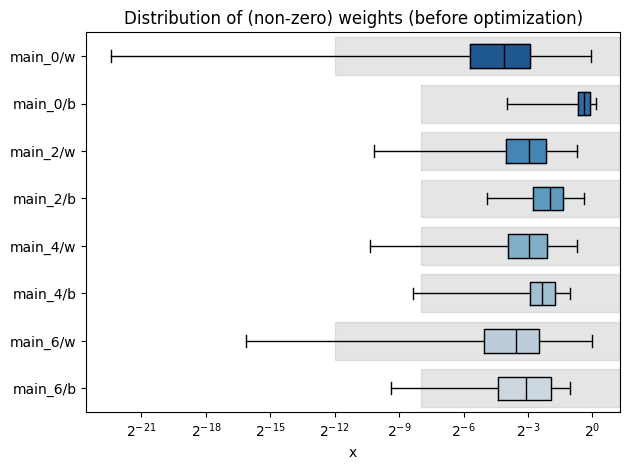

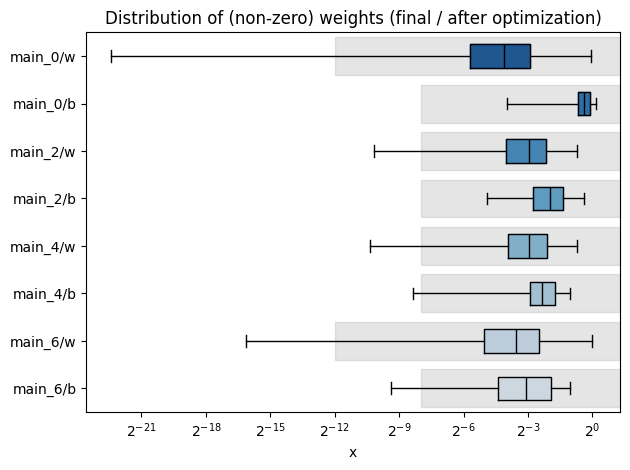

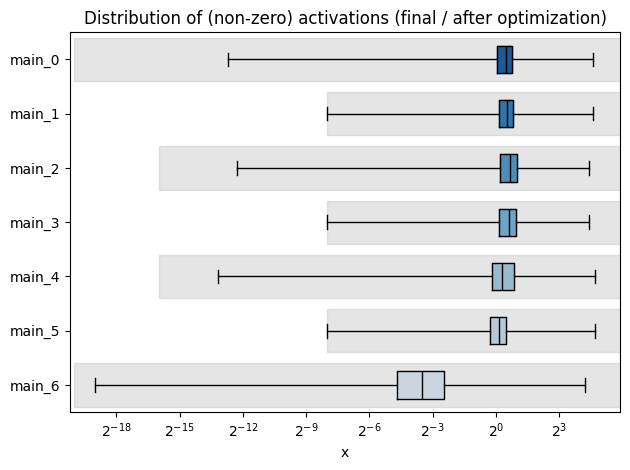

In [17]:
from hls4ml.model.profiling import numerical

for name, model in hls_models.items():
    if name == "ap_fixed<18, 10>":
        print(f"Profiling model {name}")
        # Profile the model
        profile = numerical(model=wrapped_vf, hls_model=model, X=X_test_hls[:1000])
        # Print the profiling report
        print(profile)
        # Save the profiling report to a file
        with open(f"profiling_report_{name}.txt", "w") as f:
            f.write(str(profile))

In [18]:
# compile all the models
import torch

hls_scores = {}
for name, model in hls_models.items():
    print(f"Compiling model {name}")
    # compile the model
    model.compile()
    hls_scores[name] = torch.norm(
        torch.tensor(model.predict(X_test_hls)), dim=1
    ).numpy()
    hls_auc = roc_auc_score(dataset.test_labels, hls_scores[name])
    hls_ap = average_precision_score(dataset.test_labels, hls_scores[name])
    hls_accuracy = accuracy_score(dataset.test_labels, hls_scores[name] > 10)
    print(f"Accuracy: {hls_accuracy:.4f}")
    print(f"AUC-ROC: {hls_auc:.4f}")
    print(f"Average Precision: {hls_ap:.4f}")
    results[name] = {
        "scores": hls_scores[name],
        "auc": hls_auc,
        "ap": hls_ap,
        "time": 1,
    }

Compiling model ap_fixed<32, 16>
Writing HLS project
Done
Accuracy: 0.7365
AUC-ROC: 0.8399
Average Precision: 0.8598
Compiling model ap_fixed<20, 10>
Writing HLS project
Done
Accuracy: 0.7332
AUC-ROC: 0.8397
Average Precision: 0.8598
Compiling model ap_fixed<20, 12>
Writing HLS project
Done
Accuracy: 0.7248
AUC-ROC: 0.8387
Average Precision: 0.8593
Compiling model ap_fixed<18, 12>
Writing HLS project
Done
Accuracy: 0.7006
AUC-ROC: 0.8398
Average Precision: 0.8585
Compiling model ap_fixed<18, 10>
Writing HLS project
Done
Accuracy: 0.7287
AUC-ROC: 0.8392
Average Precision: 0.8597
Compiling model ap_fixed<16, 10>
Writing HLS project
Done
Accuracy: 0.7006
AUC-ROC: 0.8398
Average Precision: 0.8585
Compiling model ap_fixed<16, 8>
Writing HLS project
Done
Accuracy: 0.7248
AUC-ROC: 0.8387
Average Precision: 0.8580


In [19]:
results["Flow Matching"] = {
    "scores": flow_scores,
    "auc": flow_auc,
    "ap": flow_ap,
    "time": 1,
}

torch.Size([100, 5, 76])
torch.Size([100, 5, 76])


Text(0.5, 0.01, '○: Initial state   •: Intermediate states   ★: Final state')

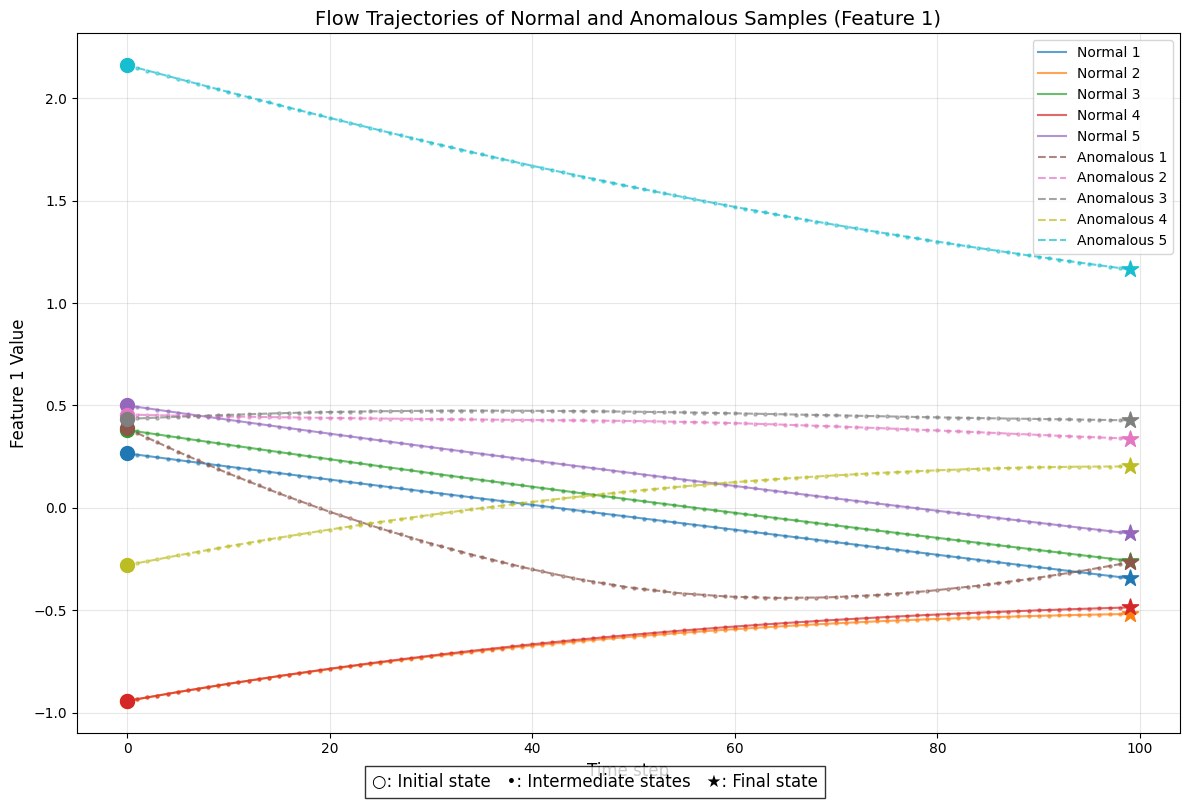

In [20]:
# try and plot some trajectories for normal and anomalous samples
# get the indices of the normal and anomalous samples
normal_indices = np.where(dataset.test_labels == 0)[0]
anomalous_indices = np.where(dataset.test_labels == 1)[0]
# get the first 5 indices of each
normal_indices = normal_indices[:5]
anomalous_indices = anomalous_indices[:5]
# plot the trajectories for the normal samples
normal_trajectories = flow_matching.return_trajectories(
    X_test[normal_indices], mode="ODE"
).swapaxes(0, 1)
anom_trajectories = flow_matching.return_trajectories(
    X_test[anomalous_indices], mode="ODE"
).swapaxes(0, 1)

# Create a figure for the first feature trajectory visualization
plt.figure(figsize=(12, 8))

# Plot the trajectories
for i, trajectory in enumerate(normal_trajectories):
    plt.plot(trajectory[:, 4], label=f"Normal {i + 1}", color=f"C{i}", alpha=0.7)
    # Add small scatter points for all states
    plt.scatter(
        range(len(trajectory)),
        trajectory[:, 4],
        marker=".",
        color=f"C{i}",
        s=20,
        alpha=0.5,
    )
    # Highlight initial and final states
    plt.scatter(0, trajectory[0, 4], marker="o", color=f"C{i}", s=100, zorder=10)
    plt.scatter(
        len(trajectory) - 1,
        trajectory[-1, 4],
        marker="*",
        color=f"C{i}",
        s=150,
        zorder=10,
    )

for i, trajectory in enumerate(anom_trajectories):
    plt.plot(
        trajectory[:, 4],
        label=f"Anomalous {i + 1}",
        linestyle="--",
        color=f"C{i + 5}",
        alpha=0.7,
    )
    # Add small scatter points for all states
    plt.scatter(
        range(len(trajectory)),
        trajectory[:, 4],
        marker=".",
        color=f"C{i + 5}",
        s=20,
        alpha=0.5,
    )
    # Highlight initial and final states
    plt.scatter(0, trajectory[0, 4], marker="o", color=f"C{i + 5}", s=100, zorder=10)
    plt.scatter(
        len(trajectory) - 1,
        trajectory[-1, 4],
        marker="*",
        color=f"C{i + 5}",
        s=150,
        zorder=10,
    )

# Add visual enhancements
plt.title("Flow Trajectories of Normal and Anomalous Samples (Feature 1)", fontsize=14)
plt.xlabel("Time step", fontsize=12)
plt.ylabel("Feature 1 Value", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc="best", fontsize=10)
plt.tight_layout()

# Add a text annotation explaining the markers
plt.figtext(
    0.5,
    0.01,
    "○: Initial state   •: Intermediate states   ★: Final state",
    ha="center",
    fontsize=12,
    bbox={"facecolor": "white", "alpha": 0.8, "pad": 5},
)

In [21]:
# # save the model, then load it
# flow_matching.save("flow_matching_model.pt")
# flow_matching_loaded  = FlowMatchingAnomalyDetector(
#     input_dim=X_train.shape[1],
#     hidden_dim=config["hidden_dim"],
#     model_type=config["model_type"],
#     num_layers=config["num_layers"],
#     dropout_rate=config["dropout_rate"],
#     use_batch_norm=config["use_batch_norm"],
#     lr=config["lr"],
#     batch_size= config["batch_size"],
#     iterations=config["iterations"],
#     print_every=config["print_every"],
#     device=config["device"],
# )
# flow_matching_loaded.load("flow_matching_model.pt")
# # Predict anomaly scores
# flow_scores_loaded, _ = flow_matching_loaded.predict(X_test, mode="ODE")
# # print mean and std of scores for normal and anomalous samples
# print(
#     f"Mean score for normal samples: {np.mean(flow_scores_loaded[dataset.test_labels == 0]):.4f}"
# )
# print(
#     f"Std score for normal samples: {np.std(flow_scores_loaded[dataset.test_labels == 0]):.4f}"
# )


## 5. Model Comparison and Visualization

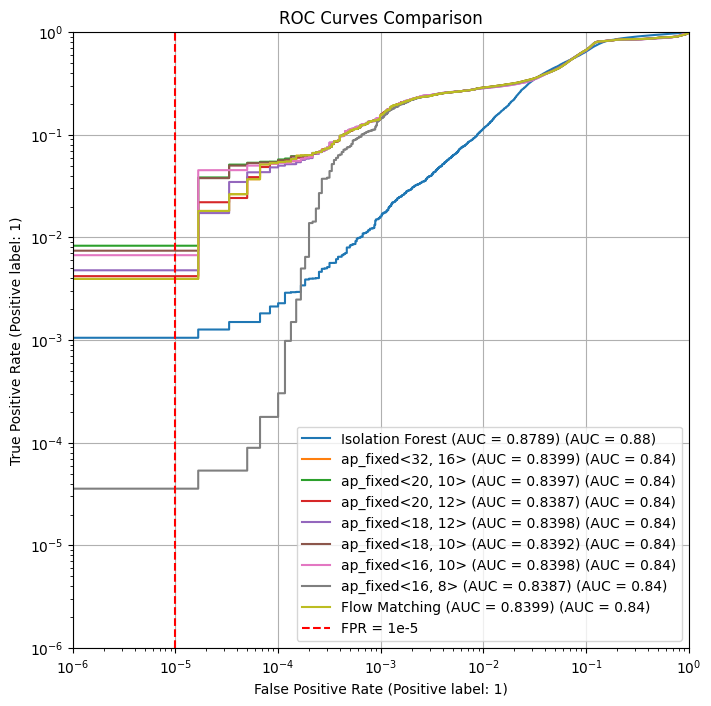

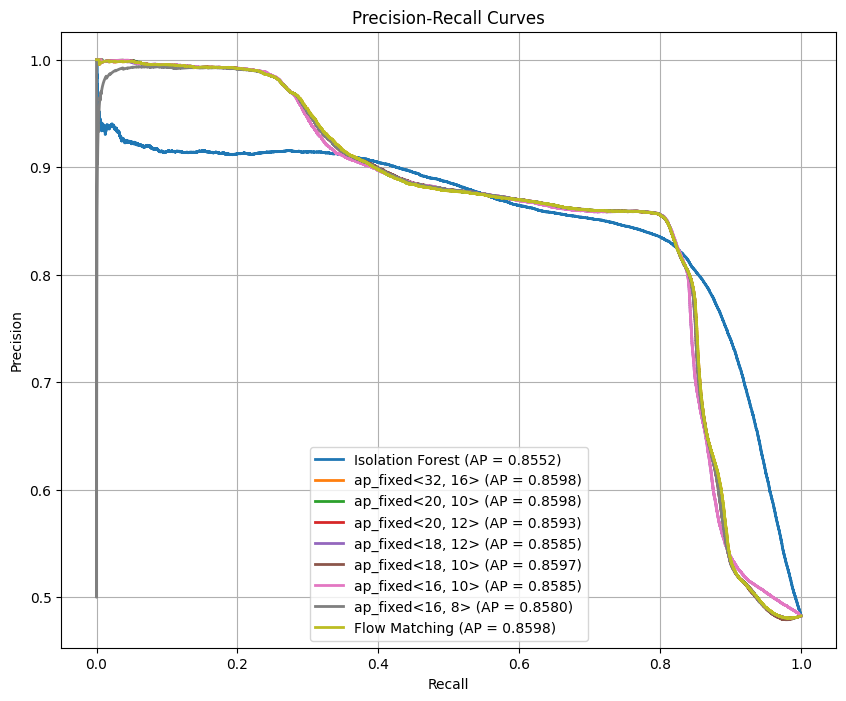

In [22]:
# Compare ROC curves
plt.figure(figsize=(10, 8))
# remove "Flow Mathcing2" form results
for name, result in results.items():
    if name == "Flow Matching2":
        # use the second dataset for this model
        RocCurveDisplay.from_predictions(
            dataset2.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )
    else:
        RocCurveDisplay.from_predictions(
            dataset.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )

plt.axvline(x=1e-5, color="red", linestyle="--", label="FPR = 1e-5")
plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-6, 1])
plt.ylim([1e-6, 1])
plt.title("ROC Curves Comparison")
plt.grid(True)
plt.legend()
plt.show()

# Compare Precision-Recall curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    if name == "Flow Matching2":
        # use the second dataset for this model
        precision, recall, _ = precision_recall_curve(
            dataset2.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")
    else:
        precision, recall, _ = precision_recall_curve(
            dataset.test_labels, result["scores"]
        )
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.grid(True)
plt.show()

## 6. Score Distributions

(60000,)


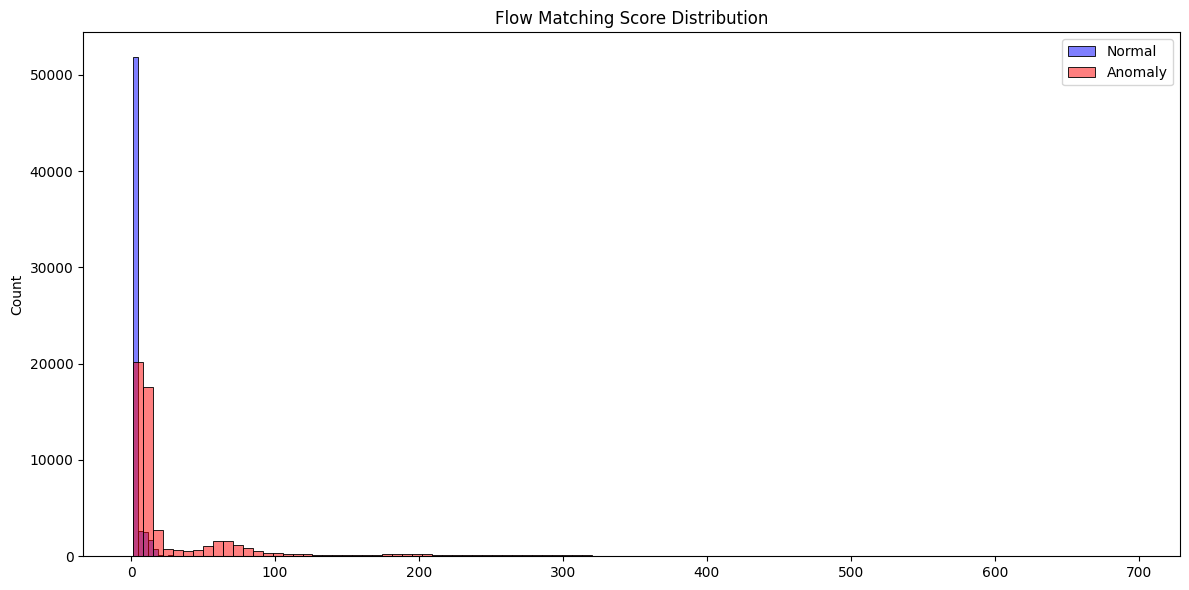

In [30]:
# Visualize anomaly scores distribution
plt.figure(figsize=(12, 6))

for i, (name, result) in enumerate(results.items(), 1):
    if name != "Flow Matching":
        continue
    plt.subplot(1, 1, 1)

    # Separate scores for normal and anomaly classes
    if name == "Flow Matching2":
        # use the second dataset for this model
        normal_scores = result["scores"][dataset2.test_labels == 0]
        print(normal_scores.shape)
        anomaly_scores = result["scores"][dataset2.test_labels == 1]
    else:
        normal_scores = result["scores"][dataset.test_labels == 0]
        print(normal_scores.shape)
        anomaly_scores = result["scores"][dataset.test_labels == 1]

    if any(anomaly_scores > 1000):
        anomaly_scores[anomaly_scores > 1000] = 1000
        normal_scores[normal_scores > 1000] = 1000
        print(f"mean score for normal samples: {np.median(normal_scores)}")
        print(f"mean score for anomalous samples: {np.mean(anomaly_scores)}")
    # Plot histograms
    sns.histplot(normal_scores, color="blue", alpha=0.5, label="Normal", bins=100)
    sns.histplot(anomaly_scores, color="red", alpha=0.5, label="Anomaly", bins=100)

    plt.title(f"{name} Score Distribution")
    plt.legend()

plt.tight_layout()
plt.show()

## 7. Results Summary

In [24]:
# Create a summary table
print("==== Summary of Results ====")
print(f"{'Model':<20} {'AUC-ROC':<10} {'Avg Precision':<15} {'Training Time (s)':<15}")
print("-" * 60)
for name, result in results.items():
    print(
        f"{name:<20} {result['auc']:<10.4f} {result['ap']:<15.4f} {result['time']:<15.2f}"
    )

==== Summary of Results ====
Model                AUC-ROC    Avg Precision   Training Time (s)
------------------------------------------------------------
Isolation Forest     0.8789     0.8552          0.49           
ap_fixed<32, 16>     0.8399     0.8598          1.00           
ap_fixed<20, 10>     0.8397     0.8598          1.00           
ap_fixed<20, 12>     0.8387     0.8593          1.00           
ap_fixed<18, 12>     0.8398     0.8585          1.00           
ap_fixed<18, 10>     0.8392     0.8597          1.00           
ap_fixed<16, 10>     0.8398     0.8585          1.00           
ap_fixed<16, 8>      0.8387     0.8580          1.00           
Flow Matching        0.8399     0.8598          1.00           
